# ALGORITMO DE REDUCCIÓN PCA SOBRE IRIS DATASET

Importamos librerías

In [1]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import numpy as  np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%time

CPU times: total: 0 ns
Wall time: 0 ns


Carga del dataset

In [2]:
iris = load_iris()
X= iris.data
variety_numbers=iris.target

Vamos a comprobar, de manera visual, como las variables discriminan en diferente grado los distintos tipos de especies. Para ello, graficaremos un histograma por cada una de las características/variables de entrada.

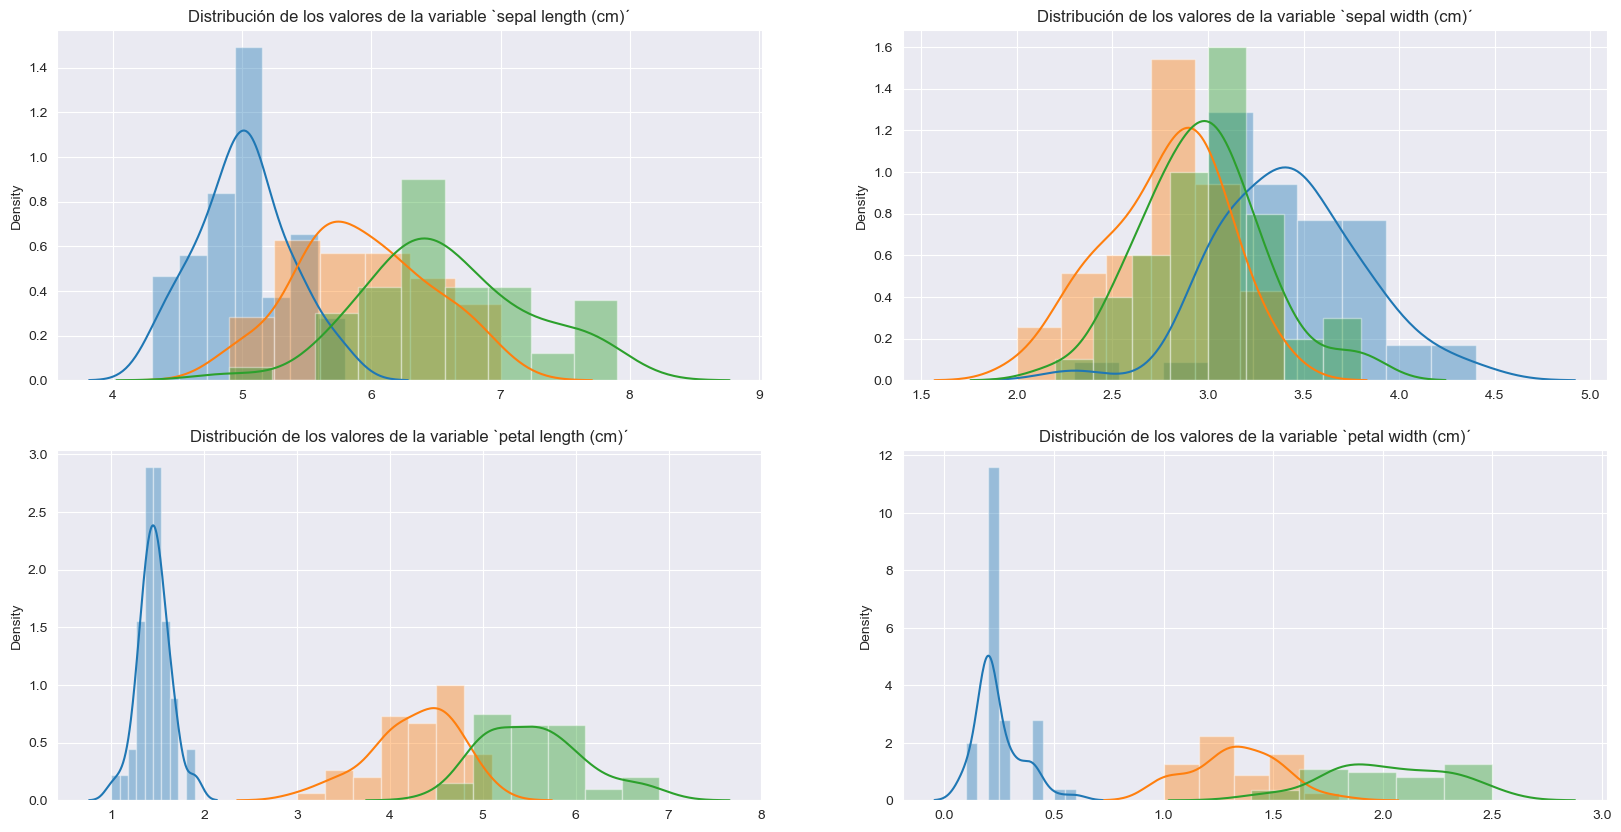

In [3]:
import seaborn as sns
fig, ax = plt.subplots(2,2,figsize=(20, 10))

for i in np.arange(2):
    for j in np.arange(2):
        for c in np.arange(len(np.unique(variety_numbers))):
            ax[i,j].set_title("Distribución de los valores de la variable `"+iris.feature_names[i*2+j]+"´")
            sns.distplot(X[variety_numbers==np.unique(variety_numbers)[c],i*2+j], ax=ax[i,j], norm_hist=True, kde=True)
        
plt.show()

Se puede observar que, mientras entre las variables correspondientes al sépalo no hay relación observable directamente, entre las variables correspondientes al pétalo esta relación resulta evidente.    
Procedemos seguidamente a aplicar el método de reducción PCA

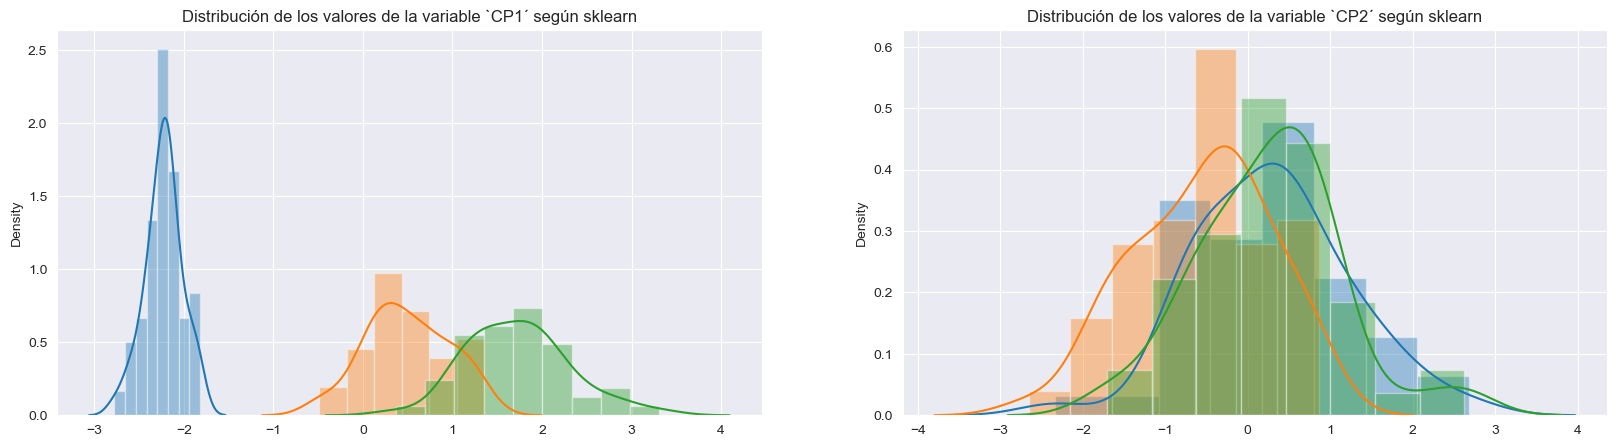

In [4]:
# Estandarización
from sklearn.preprocessing import StandardScaler
Xp = StandardScaler().fit_transform(X)
from sklearn.decomposition import PCA
Xt_sk = PCA(n_components=2).fit_transform(Xp)
fig, ax = plt.subplots(1,2,figsize=(20, 5))

for i in np.arange(2):
    for c in np.arange(len(np.unique(variety_numbers))):
        ax[i].set_title("Distribución de los valores de la variable `CP"+str(i+1)+"´ según sklearn")
        sns.distplot(Xt_sk[variety_numbers==np.unique(variety_numbers)[c],i], ax=ax[i], norm_hist=True, kde=True)

Queda claro que, después de la reducción, la componente que resulta más atractiva por su distribución es la primera.

### PCA en la práctica: mejora del rendimiento

A continuación vamos a probar el algoritmo PCA en un problema real y comprobar cómo su uso puede mejorar el rendimiento de cálculos posteriores. En este caso, se va a aplicar PCA para reducir la dimensionalidad de un dataset clásico (MNIST) y, posteriormente, entrenar un clasificador.

MNIST es un dataset que contiene unos $70000$ dígitos manuscritos, todos ellos representados por medio $784$ dimensiones. Cada dimensión contiene el color en escala de grises (0..255) de un pixel en concreto (las imágenes son de 28x28 píxeles). Hay 10 clases, que representan cada uno de los dígitos entre 0 y 9.

Empezaremos por cargar los datos desde OpenML usando la API que integra Scikit-learn:

In [5]:
from sklearn.datasets import fetch_openml

dataset, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

print('Las dimensiones de la matriz X de variables descriptivas es:',dataset.shape)
print('El tamaño del vector de etiquetas asociado es:',labels.shape)

Las dimensiones de la matriz X de variables descriptivas es: (70000, 784)
El tamaño del vector de etiquetas asociado es: (70000,)



Tras cargar los datos, la primera acción será dividir el dataset en una partición para aprendizaje y otra para test. Guardaremos $1/7$ de los datos para test ($10000$ ejemplos) y el resto los usaremos para aprendizaje.

In [6]:
from sklearn.model_selection import train_test_split

trDataset, tsDataset, trLabels, tsLabels = train_test_split(dataset, labels, 
                                                            test_size=1/7.0, random_state=0)

Siguiendo los puntos que comentábamos anteriormente, el primer paso es la estandarización de los datos. En este caso, aprenderemos los parámetros necesarios sólo a partir de los datos de aprendizaje ya que no queremos información del conjunto de test en nuestro entrenamiento!

In [7]:
# Usamos la función de estandarización de ScikitLearn
estandarizador = StandardScaler()

# Aprendemos la media y varianza de cada variable teniendo 
# en cuenta sólo los datos de aprendizaje
estandarizador.fit(trDataset)

# Y llevamos a cabo, con esos valores, la estandarización 
# de los dos subconjuntos (training y test)
trDataset = estandarizador.transform(trDataset)
tsDataset = estandarizador.transform(tsDataset)


Vamos a usar la función de scikit-learn para realizar el PCA. Esta función acepta dos parámetros complementarios: le podemos decir el número de componentes que queremos conservar (como en el ejemplo anterior con el dataset Iris) o el porcentaje de varianza explicada que queremos conservar (el número de componentes necesarias se calcula en base a ello).

En este caso, le decimos que queremos un número de componentes que nos garanticen al menos un cierto umbral de varianza (mínima) explicada. Vamos a probar varios umbrales para observar el efecto que esto tiene en el número de componentes obtenidas y en el rendimiento de un clasificador aprendido con los datos transformados resultantes:

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import timeit

for porc in np.arange(5):
    
    porcentajeVE = 1 - porc * .2 - 0.000001

    pca = PCA(porcentajeVE)

    # De manera análoga, aprendemos los parámetros (las componentes, en este 
    # caso) a partir de los datos de entrenamiento únicamente, y aplicamos la 
    # transformación a los dos subconjuntos (training y test)
    pca.fit(trDataset)

    trTransDataset = pca.transform(trDataset)
    tsTransDataset = pca.transform(tsDataset)
    
    tiempo = timeit.default_timer()

    # Aprendemos el clasificado (regresión logística)
    logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')
    logisticRegr.fit(trTransDataset, trLabels)
    
    # Usamos el clasificador para predecir sobre el dataset de test
    predLabels = logisticRegr.predict(tsTransDataset)
    
    # Medimos el rendimiento del clasificador 
    accuracy = accuracy_score(tsLabels, predLabels)
    f1 = f1_score(tsLabels, predLabels, average='macro')
    
    tiempo = timeit.default_timer() - tiempo

    print('Prueba no. {0:d}: {1:d}% de varianza explicada'.format(porc+1, int(np.round(100*porcentajeVE))))
    print(" + No. de componentes necesario:",pca.n_components_)
    print(" + Clasificador aprendido con estos datos:")
    print("    - Tiempo necesario (s.)  : {0:2.2f}".format(tiempo))
    print("    - Rendimiento (accuracy) : {0:2.5f}".format(accuracy))
    print("    - Rendimiento (medida F1): {0:2.5f}".format(f1))
    print()

Prueba no. 1: 100% de varianza explicada
 + No. de componentes necesario: 707
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 6.54
    - Rendimiento (accuracy) : 0.91260
    - Rendimiento (medida F1): 0.91116
Prueba no. 2: 80% de varianza explicada
 + No. de componentes necesario: 146
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 2.67
    - Rendimiento (accuracy) : 0.91730
    - Rendimiento (medida F1): 0.91577
Prueba no. 3: 60% de varianza explicada
 + No. de componentes necesario: 62
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 2.20
    - Rendimiento (accuracy) : 0.90650
    - Rendimiento (medida F1): 0.90466
Prueba no. 4: 40% de varianza explicada
 + No. de componentes necesario: 23
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 2.06
    - Rendimiento (accuracy) : 0.87060
    - Rendimiento (medida F1): 0.86811
Prueba no. 5: 20% de varianza explicada
 + No. de componentes nec


Es interesante observar que, en este caso, a pesar de la reducción de hasta un $40\%$ de la varianza explicada, los resultados de los clasificadores apenas se ven afectados. Es a partir de una reducción de la varianza mayor del $50\%$ cuando, en este caso, el clasificador aprendido empieza a resentirse. Mientras tanto, el coste computacional se ha reducido por 5.

# ALGORITMO DE REDUCCIÓN t-SNE

### Creación y ejecución del modelo
El método **fit_transform** aplica la reducción dimensional al conjunto X. Por tanto, debemos ser cuidadosos a partir de este momento si volvemos a usar este conjunto

In [73]:
# Crear modelo
modelo = TSNE(learning_rate = 200)
# Entrenar+transformar modelo
tsne_features = modelo.fit_transform(X)
# Primera característica
xs = tsne_features[:,0]
# Segunda característica
ys = tsne_features[:,1]

<function matplotlib.pyplot.show(close=None, block=None)>

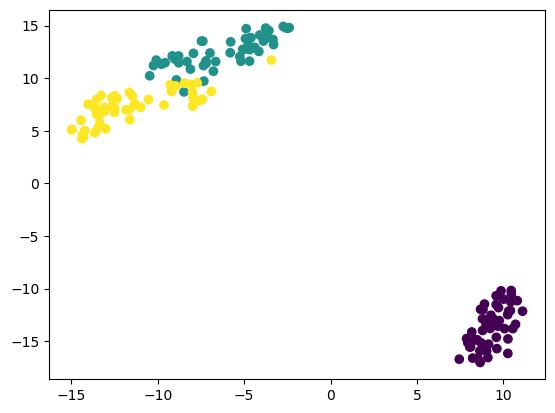

In [3]:

# Coloreado
colores=(np.array(variety_numbers))
plt.scatter(xs,ys,c=colores)
plt.show

### t-SNE sobre dataset 'Company Stock movements"

Importamos librerías

In [36]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
movements = pd.read_csv("./datasets/company-stock-movements-2010-2015-incl.csv")

Normalizamos los valores de los movimientos

In [37]:
normalized_movements = normalize(movements.iloc[:,1:])

Cargamos los nombres de las compañías en un vector para reutilizar en el ploteado

In [38]:
companies = movements.iloc[:,0]

Creación y desarrollo del modelo

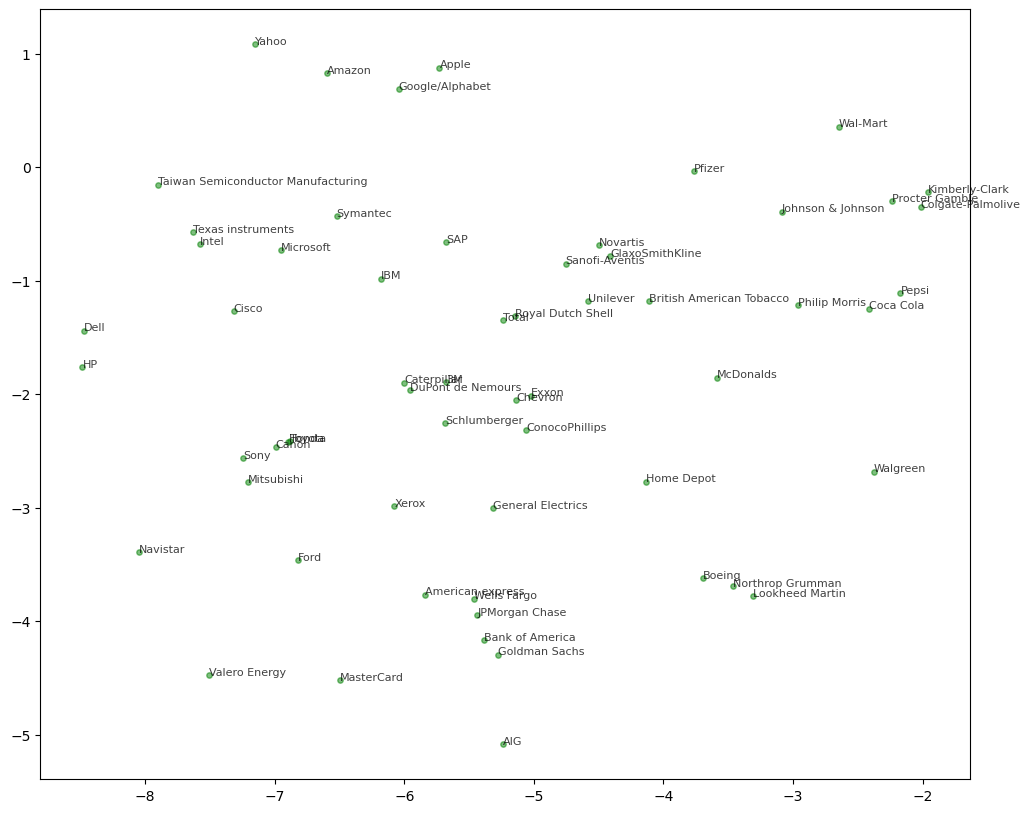

In [55]:
# Creación del modelo t-SNE
model = TSNE(learning_rate=50)

# Realizamos la reducción sobre los movimientos normalizados
tsne_features = model.fit_transform(normalized_movements)

# Seleccionamos la primera característica
xs = tsne_features[:,0]

# Seleccionamos la segunda característica
ys = tsne_features[:,1]

# Preparamos el 'scatter' plot
fig, ax = plt.subplots(1,1,figsize=(12,10))


# Nombramos los puntos
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=8, alpha=0.75)


ax.scatter(xs,ys,c='green',s=15, alpha=0.5)
plt.show()

# ALGORITMO DE REDUCCIÓN PCA

In [6]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

Creación del modelo

In [15]:
# Cargamos de nuevo el dataset
X= iris.data
variety_numbers=iris.target

CPU times: total: 0 ns
Wall time: 0 ns


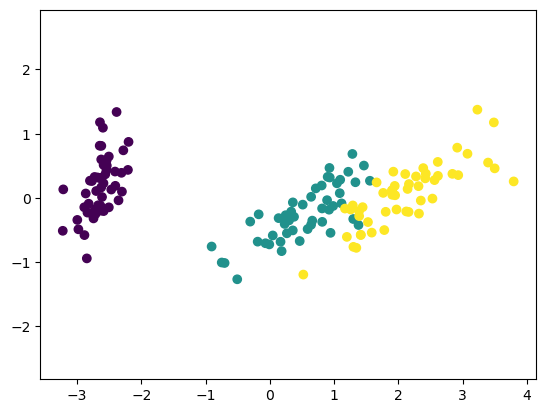

Valor del índice de correlación de Pearson:  0.9999999999999991


In [16]:
%time
# Creación del modelo
modelo = PCA()
# Aplicación de fit_transform
pca_features = modelo.fit_transform(X)
# Primera característica
xs = pca_features[:,0]
# Segunda característica
ys = pca_features[:,1]
# Ploteado
plt.scatter(xs,ys,c=colores)
plt.axis('equal')
plt.show()

# Mostramos coeficiente de correlación de Pearson
correlacion, pvalue = pearsonr(xs,ys)
print("Valor del índice de correlación de Pearson: ", pvalue)

Como se puede comprobar, según este valor, se da una correlación positiva casi perfecta (muy cercana a 1)